In [93]:
from pathlib import Path
import json
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb

In [94]:
# ----------------- CONFIG -----------------
PROJECT_ROOT  = Path.cwd().parent        # notebook inside Model_training/
DATA_PATH     = PROJECT_ROOT / "preprocessed_aqi_data (3).csv"
FEATURES_JSON = PROJECT_ROOT / "final_feature_list.json"
OUT_DIR       = PROJECT_ROOT / "predictions"
OUT_DIR.mkdir(parents=True, exist_ok=True)

WINDOW_SIZE     = 24       # past hours per sample
PREDICT_HORIZON = 72       # next 72 hours (3 days)
TARGET_COL      = "us_aqi"
TIME_COL_CANDS  = ["time", "datetime"] 


In [95]:
# LightGBM (more conservative for better long-horizon stability)
LGBM_PARAMS = dict(
    n_estimators=1200,
    learning_rate=0.03,
    num_leaves=31,
    min_child_samples=50,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.5,
    reg_lambda=0.8,
    random_state=42
)

In [96]:
# ------------------- LOAD & PARSE TIME (DAY-FIRST) -------------------
df = pd.read_csv(DATA_PATH)

# pick time column name automatically
for c in TIME_COL_CANDS:
    if c in df.columns:
        TIME_COL = c
        break
else:
    raise ValueError(f"No datetime column found. Expected one of: {TIME_COL_CANDS}")

# clean & parse as day-first to match your “4/8/25 = 4 Aug 2025”
raw_time = (
    df[TIME_COL].astype(str)
      .str.strip()
      .str.replace("\u00A0", " ", regex=False)
      .str.replace("\u202F", " ", regex=False)
)
df[TIME_COL] = pd.to_datetime(raw_time, dayfirst=True, errors="coerce")

# sort chronologically
df = df.sort_values(TIME_COL).reset_index(drop=True)

In [97]:
# ------------------- FEATURES -------------------
feat_cols = json.loads(FEATURES_JSON.read_text())
missing = [c for c in feat_cols + [TARGET_COL, TIME_COL] if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns in data: {missing}")

# ------------------- TRAIN-ONLY WINSORIZATION + IMPUTE -------------------
def build_sequences(frame, features, target, window, horizon):
    Xs, Ys = [], []
    Xmat = frame[features].values
    yvec = frame[target].values
    n = len(frame)
    limit = n - window - horizon
    for i in range(limit):
        Xs.append(Xmat[i:i+window].reshape(-1))                # (window * F,)
        Ys.append(yvec[i+window:i+window+horizon])             # (horizon,)
    return np.array(Xs), np.array(Ys), limit

# First pass to know how many windows we’ll have
_, _, limit = build_sequences(df, feat_cols, TARGET_COL, WINDOW_SIZE, PREDICT_HORIZON)
if limit <= 0:
    raise ValueError("Not enough rows to make sliding windows. Add more data.")

# map “train windows” back to raw rows used by their inputs
train_windows = int(limit * 0.8)
raw_end_for_train_inputs = (train_windows - 1) + WINDOW_SIZE  # inclusive index of last row used by X_train windows
raw_end_for_train_inputs = max(raw_end_for_train_inputs, WINDOW_SIZE)  # safety

# compute caps on TRAIN INPUT rows only
numeric_feats = [c for c in feat_cols if pd.api.types.is_numeric_dtype(df[c])]
low = df.loc[:raw_end_for_train_inputs, numeric_feats].quantile(0.01).to_dict()
high = df.loc[:raw_end_for_train_inputs, numeric_feats].quantile(0.99).to_dict()
for c in numeric_feats:
    df[c] = df[c].clip(lower=low[c], upper=high[c])

# median impute using TRAIN INPUT rows only, then apply to all
train_medians = df.loc[:raw_end_for_train_inputs, feat_cols].median(numeric_only=True).to_dict()
df[feat_cols] = df[feat_cols].fillna(train_medians)

In [98]:
# ------------------- REBUILD SEQUENCES AFTER CLEANING -------------------
X_seq, y_seq, limit = build_sequences(df, feat_cols, TARGET_COL, WINDOW_SIZE, PREDICT_HORIZON)

# ------------------- TRAIN/VAL SPLIT (chronological 80/20) -------------------
X_train, X_val, y_train, y_val = train_test_split(
    X_seq, y_seq, test_size=0.2, shuffle=False
)

# ------------------- TRAIN MODEL -------------------
model = MultiOutputRegressor(lgb.LGBMRegressor(**LGBM_PARAMS), n_jobs=-1)
model.fit(X_train, y_train)

# ------------------- EVALUATION (prints only) -------------------
y_pred_val = model.predict(X_val)
mae_list, rmse_list, r2_list = [], [], []
for h in range(PREDICT_HORIZON):
    yt = y_val[:, h]
    yp = y_pred_val[:, h]
    mae_list.append(mean_absolute_error(yt, yp))
    rmse_list.append(mean_squared_error(yt, yp, squared=False))
    r2_list.append(r2_score(yt, yp))

print("\n=== Validation Metrics (80/20 holdout) ===")
print(f"Overall MAE (avg):  {np.mean(mae_list):.3f}")
print(f"Overall RMSE (avg): {np.mean(rmse_list):.3f}")
print(f"Overall R² (avg):   {np.mean(r2_list):.3f}")
print(f"First 12 horizons MAE: {[round(m, 3) for m in mae_list[:12]]}")
if PREDICT_HORIZON >= 24: print(f"24h MAE: {mae_list[23]:.3f}")
if PREDICT_HORIZON >= 48: print(f"48h MAE: {mae_list[47]:.3f}")
if PREDICT_HORIZON >= 72: print(f"72h MAE: {mae_list[71]:.3f}")


=== Validation Metrics (80/20 holdout) ===
Overall MAE (avg):  7.365
Overall RMSE (avg): 8.563
Overall R² (avg):   -1.868
First 12 horizons MAE: [0.538, 0.669, 0.757, 0.82, 0.953, 1.19, 1.386, 1.582, 1.76, 1.996, 2.188, 2.421]
24h MAE: 5.072
48h MAE: 9.165
72h MAE: 12.752


In [101]:
# ------------------- FORECAST NEXT 72 HOURS (ONE CSV) -------------------
# last window of features (after cleaning)
last_window = df[feat_cols].values[-WINDOW_SIZE:].reshape(1, -1)
future_pred = model.predict(last_window)[0]   # (72,)

# anchor = last non-NaT time; start = +1 hour
last_valid_time = df.loc[df[TIME_COL].notna(), TIME_COL].iloc[-1]
start = last_valid_time.floor("H") + pd.Timedelta(hours=1)
future_times = pd.date_range(start=start, periods=PREDICT_HORIZON, freq="h")

# format as d/m/yy HH:MM (so 9/8/25 = 9 Aug 2025)
ft = pd.Series(future_times)
formatted_dt = (
    ft.dt.day.astype(str) + "/" +
    ft.dt.month.astype(str) + "/" +
    ft.dt.strftime("%y") + " " +
    ft.dt.strftime("%H:%M")
)

forecast_df = pd.DataFrame({
    "datetime": formatted_dt,
    "predicted_aqi_us": future_pred
})

forecast_df.to_csv(OUTPUT_FILE, index=False)
print(f"\nSaved forecast → {OUTPUT_FILE}")
print("First/last timestamps:", forecast_df['datetime'].iloc[0], "→", forecast_df['datetime'].iloc[-1])


Saved forecast → aqi_72h_forecast.csv
First/last timestamps: 10/8/25 00:00 → 12/8/25 23:00


In [103]:
from pathlib import Path
import json, joblib

SAVE_DIR = Path("models/current")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

MODEL_PATH   = SAVE_DIR / "lgbm_multioutput_72h.joblib"
META_PATH    = SAVE_DIR / "metadata.json"

# save model
joblib.dump(model, MODEL_PATH)

# save metadata needed for inference
meta = {
    "features": feat_cols,                 # list of feature column names
    "target_col": TARGET_COL,              # "us_aqi"
    "time_col": TIME_COL,                  # e.g. "time" or "datetime"
    "window_size": WINDOW_SIZE,            # 24
    "horizon": PREDICT_HORIZON,            # 72
    "dayfirst": True,                      # we parse like 4/8/25 -> 4 Aug
    "winsor_low": low,                     # 1% caps computed on train inputs
    "winsor_high": high,                   # 99% caps
    "train_medians": train_medians,        # feature medians (train inputs)
}
META_PATH.write_text(json.dumps(meta, indent=2))

print("Saved model →", MODEL_PATH)
print("Saved metadata →", META_PATH)


Saved model → models\current\lgbm_multioutput_72h.joblib
Saved metadata → models\current\metadata.json


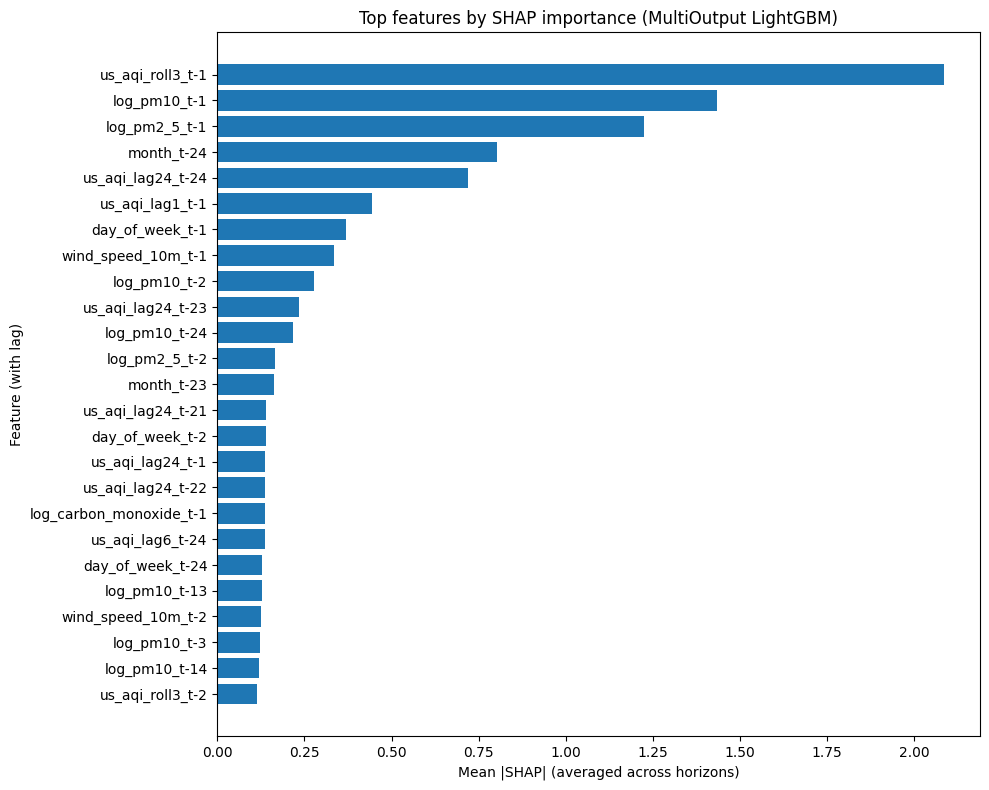

In [104]:
# --- SHAP bar chart for MultiOutput LightGBM (averaged across horizons) ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Ensure SHAP available
try:
    import shap
except ImportError:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "shap"])
    import shap

# 2) Rebuild readable column names for the flattened sliding window
#    We built windows as X[i:i+WINDOW].reshape(-1) with oldest→newest order.
flat_cols = []
for lag in range(WINDOW_SIZE, 0, -1):  # 24..1 (t-24 ... t-1)
    for f in feat_cols:
        flat_cols.append(f"{f}_t-{lag}")

# 3) Put training matrix into a DataFrame with those names
X_train_df = pd.DataFrame(X_train, columns=flat_cols)

# 4) Subsample for SHAP speed
n_sample = min(500, len(X_train_df))
sample = X_train_df.sample(n=n_sample, random_state=42)

# 5) Compute SHAP per-horizon, then average |SHAP| across horizons
per_h_abs_means = []
for h, est in enumerate(model.estimators_):       # one LightGBM per horizon
    explainer = shap.TreeExplainer(est)
    sv = explainer.shap_values(sample)            # shape: [n_sample, n_features]
    abs_mean = np.abs(sv).mean(axis=0)            # mean |SHAP| per feature
    per_h_abs_means.append(abs_mean)

mean_abs_shap = np.vstack(per_h_abs_means).mean(axis=0)  # average across horizons

imp_df = (
    pd.DataFrame({"feature": flat_cols, "mean_abs_shap": mean_abs_shap})
      .sort_values("mean_abs_shap", ascending=False)
      .head(25)  # top-25
)

# 6) Bar chart (horizontal, top on top)
plt.figure(figsize=(10, 8))
plt.barh(imp_df["feature"][::-1], imp_df["mean_abs_shap"][::-1])
plt.xlabel("Mean |SHAP| (averaged across horizons)")
plt.ylabel("Feature (with lag)")
plt.title("Top features by SHAP importance (MultiOutput LightGBM)")
plt.tight_layout()
plt.show()
